In [1]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def revnet2d_step(name, z, logdet, hps, reverse):
    with tf.variable_scope(name):

        shape = Z.int_shape(z)
        n_z = shape[3]
        assert n_z % 2 == 0

        if not reverse:

            z, logdet = Z.actnorm("actnorm", z, logdet=logdet)

            if hps.flow_permutation == 0:
                z = Z.reverse_features("reverse", z)
            elif hps.flow_permutation == 1:
                z = Z.shuffle_features("shuffle", z)
            elif hps.flow_permutation == 2:
                z, logdet = invertible_1x1_conv("invconv", z, logdet)
            else:
                raise Exception()

            z1 = z[:, :, :, :n_z // 2]
            z2 = z[:, :, :, n_z // 2:]

            if hps.flow_coupling == 0:
                z2 += f("f1", z1, hps.width)
            elif hps.flow_coupling == 1:
                h = f("f1", z1, hps.width, n_z)
                shift = h[:, :, :, 0::2]
                # scale = tf.exp(h[:, :, :, 1::2])
                scale = tf.nn.sigmoid(h[:, :, :, 1::2] + 2.)
                z2 += shift
                z2 *= scale
                logdet += tf.reduce_sum(tf.log(scale), axis=[1, 2, 3])
            else:
                raise Exception()

            z = tf.concat([z1, z2], 3)

        else:

            z1 = z[:, :, :, :n_z // 2]
            z2 = z[:, :, :, n_z // 2:]

            if hps.flow_coupling == 0:
                z2 -= f("f1", z1, hps.width)
            elif hps.flow_coupling == 1:
                h = f("f1", z1, hps.width, n_z)
                shift = h[:, :, :, 0::2]
                # scale = tf.exp(h[:, :, :, 1::2])
                scale = tf.nn.sigmoid(h[:, :, :, 1::2] + 2.)
                z2 /= scale
                z2 -= shift
                logdet -= tf.reduce_sum(tf.log(scale), axis=[1, 2, 3])
            else:
                raise Exception()

            z = tf.concat([z1, z2], 3)

            if hps.flow_permutation == 0:
                z = Z.reverse_features("reverse", z, reverse=True)
            elif hps.flow_permutation == 1:
                z = Z.shuffle_features("shuffle", z, reverse=True)
            elif hps.flow_permutation == 2:
                z, logdet = invertible_1x1_conv(
                    "invconv", z, logdet, reverse=True)
            else:
                raise Exception()

            z, logdet = Z.actnorm("actnorm", z, logdet=logdet, reverse=True)

return z, logdet

In [ ]:
tf.nn.conv3d()

In [ ]:
        w = tf.get_variable("w", [k_h, k_w, k_z, input_.get_shape()[-1], output_dim],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        if spectral_normed:
            conv = tf.nn.conv3d(input_, spectral_normed_weight(w, update_collection=update_collection, num_iters=num_iters),
                              strides=[1, d_h, d_w, d_z, 1], padding=padding)
        else:
            conv = tf.nn.conv3d(input_, w, strides=[1, d_h, d_w, d_z, 1], padding=padding)

        biases = tf.get_variable("b", [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.bias_add(conv, biases)
        if with_w:
            return conv, w, biases


In [65]:

def f_net3d(name, h, width, n_out=None):

    k_h, k_w, k_z = [3]*3
    fan_in = k_h * k_w * k_z * h.get_shape().as_list()[-1]
    stddev = tf.sqrt(2. / (fan_in))
    n_out = n_out or int(h.get_shape()[4])

    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
#         if scope_has_variables(scope):
#             scope.reuse_variables()        
        w1 = tf.get_variable("w1", [3, 3, 3, h.get_shape()[-1], width],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        w2 = tf.get_variable("w2", [3, 3, 3, width, width],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        wout = tf.get_variable("wout", [3, 3, 3, width, n_out],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        
        h = tf.nn.relu(tf.nn.conv3d(h, w1, strides=[1, 1, 1, 1, 1], padding='SAME'))
        h = tf.nn.relu(tf.nn.conv3d(h, w2, strides=[1, 1, 1, 1, 1], padding='SAME'))
        h = tf.nn.conv3d(h, wout, strides=[1, 1, 1, 1, 1], padding='SAME')
    return h


class AffineGlow3d(tfb.Bijector):
    def __init__(self, width=4,
               name="affine"):

#         self.name = name
        self.width = width
        super(AffineGlow3d, self).__init__(
            #is_constant_jacobian=False,
            forward_min_event_ndims=1,
            dtype=None,
            validate_args=False,
            name=name)


    def _forward(self, x):

        n_x = int(x.get_shape()[4])
        assert n_x % 2 == 0

        x1 = x[:, :, :, :, :n_x // 2]
        x2 = x[:, :, :, :, n_x // 2:]

        h = f_net3d(self._name + "/f1", x1, width=self.width, n_out=n_x)
        shift = h[:, :, :, :, 0::2]
        # scale = tf.exp(h[:, :, :, 1::2])
        scale = tf.nn.sigmoid(h[:, :, :, :, 1::2] + 2.)
        x2 += shift
        x2 *= scale
        
        z = tf.concat([x1, x2], 4)
        
        return z
        


    def _inverse(self, x):
        n_x = int(x.get_shape()[4])
        assert n_x % 2 == 0

        x1 = x[:, :, :, :, :n_x // 2]
        x2 = x[:, :, :, :, n_x // 2:]

        h = f_net3d(self._name + "/f1", x1, width=self.width, n_out=n_x)
        shift = h[:, :, :, :, 0::2]

        # scale = tf.exp(h[:, :, :, 1::2])
        scale = tf.nn.sigmoid(h[:, :, :, :, 1::2] + 2.)
        x2 /= scale
        x2 -= shift

        z = tf.concat([x1, x2], 4)


        return z
        

    def _forward_log_det_jacobian(self, x):
        
        shape = x.int_shape(z)
        n_x = shape[4]
        assert n_x % 2 == 0

        x1 = x[:, :, :, :, :n_x // 2]
        x2 = x[:, :, :, :, n_x // 2:]

        h = f_net3d(self._name + "/f1", z1, hps.width, n_x)
        shift = h[:, :, :, :, 0::2]
        # scale = tf.exp(h[:, :, :, 1::2])
        scale = tf.nn.sigmoid(h[:, :, :, :, 1::2] + 2.)
        logdet = tf.reduce_sum(tf.log(scale), axis=[1, 2, 3, 4])
        return logdet


In [66]:
from tfops import Squeeze3d

In [87]:
 tf.reset_default_graph()


cube_size = nc
nchannels = 1
feature_layer = tf.placeholder(tf.float32, shape=[None, 32,  32,  32,  1], name='input')
# chain = tfb.Chain([tfb.Invert(Squeeze3d(event_shape_in=[cube_size, cube_size, cube_size, 1])),
#                 AffineGlow3d(), AffineGlow3d(),
#                 Squeeze3d(event_shape_in=[cube_size, cube_size, cube_size, 1])])
chain = tfb.Chain([tfb.Invert(Squeeze3d(event_shape_in=[cube_size, cube_size, cube_size, 1])),
                AffineGlow3d(name='af1'), AffineGlow3d(name='af2'),
    Squeeze3d(event_shape_in=[cube_size, cube_size, cube_size, 1])])
# chain = tfb.Chain([AffineGlow3d(name='af1'), AffineGlow3d(name='af2')])

bijection = chain

net = bijection.forward(feature_layer)
net2 = bijection.inverse(net+0)



# inp = lins[:8].reshape(1, nc, nc, nc, 8)
inp = lins[:1].reshape(1, nc, nc, nc, 1)

with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
    pred = sess.run([net, net2], {feature_layer:inp})
#     inp2 = sess.run(net, {feature_layer:pred[0]})
    
# # diff = (abs(pred[1] - cube_features[0][:2])/cube_features[0][:2])
# diff = (abs(pred[1] - cube_features[0][:1]))
# diff[~np.isnan(diff)].max()

In [94]:
np.unique(pred[1]/inp )

array([0.9996254 , 0.9998254 , 0.99988985, 0.99989796, 0.9999066 ,
       0.9999179 , 0.99996054, 0.99996495, 0.9999734 , 0.9999749 ,
       0.99997646, 0.99997693, 0.99997944, 0.9999814 , 0.9999823 ,
       0.9999833 , 0.9999846 , 0.9999849 , 0.9999859 , 0.9999861 ,
       0.9999864 , 0.9999878 , 0.9999899 , 0.9999901 , 0.9999906 ,
       0.9999914 , 0.9999917 , 0.9999918 , 0.9999924 , 0.99999243,
       0.99999285, 0.9999932 , 0.99999326, 0.99999356, 0.9999937 ,
       0.99999386, 0.999994  , 0.99999404, 0.9999941 , 0.9999944 ,
       0.99999446, 0.9999946 , 0.99999475, 0.9999948 , 0.9999949 ,
       0.99999523, 0.99999535, 0.99999547, 0.9999956 , 0.99999565,
       0.99999577, 0.9999958 , 0.99999595, 0.99999607, 0.9999962 ,
       0.99999624, 0.9999963 , 0.99999636, 0.9999965 , 0.99999654,
       0.9999966 , 0.9999967 , 0.99999684, 0.9999969 , 0.99999696,
       0.999997  , 0.9999971 , 0.99999714, 0.9999972 , 0.99999726,
       0.9999973 , 0.9999974 , 0.99999744, 0.9999975 , 0.99999

In [92]:
(pred[1]/inp == 1).sum()/inp.size

0.7532958984375

In [88]:
(pred[0]/inp == 1).sum()/inp.size

0.5

In [77]:
inp2/inp

array([[[[[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
            1.03850102e+00,  2.17304516e+00, -9.35180092e+00],
          [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
            1.28158045e+00,  1.38401012e+01, -3.15258670e+00],
          [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
            3.18727165e-01,  3.24359155e+00, -8.16763759e-01],
          ...,
          [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
            7.50364065e-01, -8.38734245e+00, -1.81309474e+00],
          [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
            6.83349729e-01,  5.25221825e+00,  1.83348513e+00],
          [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
           -1.02408504e+00,  5.09520912e+00,  2.07429862e+00]],

         [[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
            6.76969588e-01,  1.42555118e-01,  1.87415922e+00],
          [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
      

In [9]:
sys.path.append('../../utils/flowpm/')
import tfpmconfig, tfpm
import tfpmfuncs as tfpf
import tfpmfuncs
sys.path.append('../../utils/')
import tools


bs, nc = 100, 32
config = tfpmconfig.Config(bs=bs, nc=nc)
# path = '../../data/toy/L0100_N0032/S{:04d}/'
path = '../../../galmodel/data/toy/L0100_N0032/S{:04d}/'
seed = 0 

In [10]:
lins, fins, finsample = [], [], []
for seed in range(1000):
    lins.append(np.load(path.format(seed)+'s.npy'))
    fins.append(np.load(path.format(seed)+'d.npy'))
    finsample.append(np.load(path.format(seed)+'p.npy'))

lins = np.array(lins)
fins = np.array(fins)
finsample = np.array(finsample)

array([[[[ 3.08082294e+00,  8.06454539e-01,  1.73082376e+00, ...,
           4.60043001e+00,  1.74557424e+00,  9.08963442e-01],
         [-2.07858300e+00, -3.64492798e+00, -1.40137696e+00, ...,
           6.92936897e-01, -3.25308919e-01, -2.65547037e+00],
         [-1.10965371e-02, -1.67928171e+00, -3.39520812e+00, ...,
           2.53239727e+00,  1.85330796e+00,  1.32452011e+00],
         ...,
         [-3.79860580e-01,  2.45028353e+00,  3.55675268e+00, ...,
          -1.23521090e-01,  3.45578742e+00, -1.74755573e+00],
         [-7.30813682e-01,  1.56038952e+00,  1.32784855e+00, ...,
           7.96038389e-01,  1.48301148e+00,  2.76047915e-01],
         [-9.31455314e-01,  5.32411337e-01,  8.29112053e-01, ...,
           3.40064192e+00,  9.02073860e-01, -1.04807544e+00]],

        [[ 2.78807950e+00, -1.06567156e+00, -3.37237811e+00, ...,
           3.58590937e+00,  6.48118496e+00,  2.11930156e+00],
         [-2.11178899e+00,  2.20613003e-01, -2.55286217e+00, ...,
          -2.15734839e

In [2]:
from sklearn import cluster, datasets, mixture

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __p

In [3]:
noisy_moons = datasets.make_moons(n_samples=10000, noise=.05)[0].astype(np.float32)

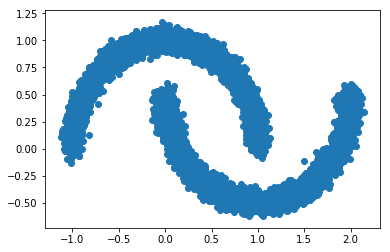

In [4]:
scatter(noisy_moons[:,0], noisy_moons[:,1])

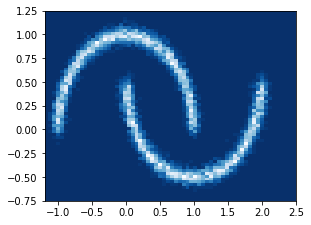

In [5]:
figure(figsize=(4.5,3.5),frameon = False)
var = 0.0
hist2d(noisy_moons[:,0]+var*randn(len(noisy_moons)),
       noisy_moons[:,1] +var*randn(len(noisy_moons)),64,vmax=30,range=[[-1.2,2.5],[-0.75,1.25]],cmap='Blues_r',vmin=0);

#title('Target distribution')

## Defining the model

In [6]:
tf.reset_default_graph()
chain = [ tfp.bijectors.MaskedAutoregressiveFlow(
                                shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=[256,256],
                                                                                              activation=tf.nn.relu)),
             tfb.Permute([1,0]),
              tfp.bijectors.MaskedAutoregressiveFlow(
                                shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=[256,256],
                                                                                            activation=tf.nn.relu)),

              tfb.Permute([1,0]),
              tfp.bijectors.MaskedAutoregressiveFlow(
                                shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=[256,256],
                                                                                              activation=tf.nn.relu)),
              tfb.Permute([1,0]),
              tfp.bijectors.MaskedAutoregressiveFlow(
                                shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=[256,256],
                                                                                              activation=tf.nn.relu)),
            ]
bij = tfb.Chain(chain)

prior  = tfd.MultivariateNormalDiag(loc=tf.zeros(2), scale_identity_multiplier=1.0)
distribution = tfd.TransformedDistribution(prior, bijector=bij)

batch_size = 1024

x = tf.placeholder(tf.float32, shape=(batch_size,2))
lr = tf.placeholder_with_default(0.001, shape=())

samples = distribution.sample(1024)

In [7]:
loss = - tf.reduce_mean(distribution.log_prob(x))

In [8]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
gradients, variables = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
opt_op = optimizer.apply_gradients(zip(gradients, variables))

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [10]:
losses = []

In [11]:
for i in range(5000):
    ims = datasets.make_moons(n_samples=batch_size, noise=.05)[0].astype(np.float32)
    _, l = sess.run([opt_op, loss], feed_dict={x:ims, lr:0.001})
    losses.append(l)
    if i %100 ==0:
        print(i, l)

0 2.4513268
100 1.1312675
200 1.0587715
300 0.96542585
400 0.7659377
500 0.5704173
600 0.49142337
700 0.5249655
800 0.45957255
900 0.4443021
1000 0.39443704
1100 0.3655944
1200 0.40368327
1300 0.37749076
1400 0.33410248
1500 0.398799
1600 0.33694825
1700 0.36606553
1800 0.36529398
1900 0.38451904
2000 0.3356193
2100 0.33646435
2200 0.297472
2300 0.38078308
2400 0.34433585
2500 0.3441179
2600 0.33108404
2700 0.3743043
2800 0.32042247
2900 0.3078068
3000 0.3618656
3100 0.34685597
3200 0.37769923
3300 0.34961522
3400 0.33246866
3500 0.37164444
3600 0.33567318
3700 0.34764683
3800 0.3431865
3900 0.3178877
4000 0.38033047
4100 0.31925717
4200 0.28871587
4300 0.37454128
4400 0.3684007
4500 0.38565695
4600 0.34573796
4700 0.28571403
4800 0.32618043
4900 0.32022303


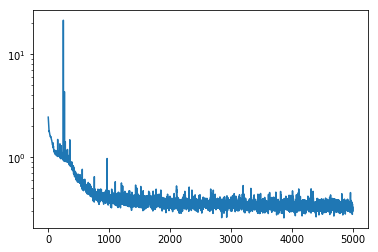

In [12]:
plot(losses)
yscale('log')

In [13]:
fake = sess.run(distribution.sample(10000))

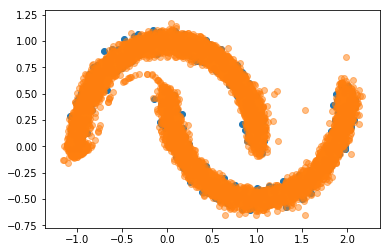

In [14]:
scatter(noisy_moons[:1024,0], noisy_moons[:1024,1])
scatter(fake[:,0], fake[:,1],alpha=0.5)

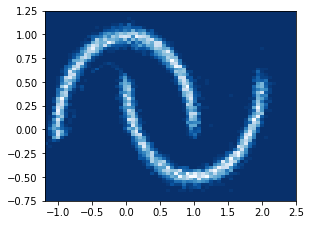

In [15]:
figure(figsize=(4.5,3.5),frameon = False)
hist2d(fake[:,0], fake[:,1],64,vmax=30,range=[[-1.2,2.5],[-0.75,1.25]],cmap='Blues_r',vmin=0);


(-1.2, 2.25)

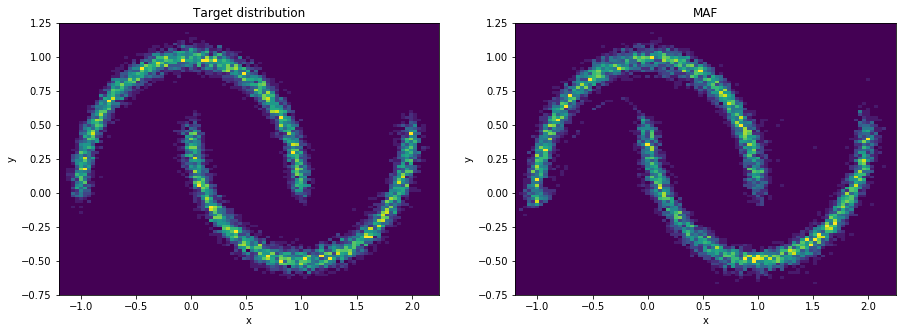

In [16]:
figure(figsize=(15,5))

subplot(121)
var = 0.0
hist2d(noisy_moons[:,0]+var*randn(len(noisy_moons)),
       noisy_moons[:,1] +var*randn(len(noisy_moons)),100,vmax=15,range=[[-1.2,2.5],[-0.75,1.25]]);
xlabel('x')
ylabel('y')
title('Target distribution')

xlim(-1.2,2.25)
xlim(-1.2,2.25)

subplot(122)
hist2d(fake[:,0], fake[:,1],100,vmax=15,range=[[-1.2,2.5],[-0.75,1.25]]);
xlabel('x')
ylabel('y')
title('MAF')
xlim(-1.2,2.25)
xlim(-1.2,2.25)